Load Important libraries

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import joblib


Load dataset

In [160]:

# Load the datasets
prices_df = pd.read_csv('/content/Food_Prices_Kenya.csv')
counties_df = pd.read_excel('/content/Kenyan_Counties_with_Regions.xlsx')


Exploratoratory Data Analysis

In [161]:
prices_df.head()

,Year,Month,Region,Commodity,Unit,Priceflag,Pricetype,Currency,Price,Usdprice,...,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,#year,#month,#region,#commodity,#unit,#priceflag,#pricetype,#currency,#price,#usdprice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,January,Coast,Maize,KG,actual,Retail,KES,16.13,0.2235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006,February,Coast,Maize,KG,actual,Retail,KES,15.93,0.2208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006,March,Coast,Maize,KG,actual,Retail,KES,16.03,0.2221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,April,Coast,Maize,KG,actual,Retail,KES,16.63,0.2305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
counties_df.head()

,Region,County
0,Coast,Mombasa
1,Coast,Kwale
2,Coast,Kilifi
3,Coast,Tana River
4,Coast,Lamu


In [163]:
# prompt: drop columns with more than 30% null values

# Calculate the percentage of null values in each column
null_percentages = prices_df.isnull().sum() / len(prices_df) * 100

# Drop columns with more than 30% null values
columns_to_drop = null_percentages[null_percentages > 30].index
prices_df = prices_df.drop(columns=columns_to_drop)


In [164]:
# Calculate the percentage of null values in each column
null_percentages = counties_df.isnull().sum() / len(counties_df) * 100

# Drop columns with more than 30% null values
columns_to_drop = null_percentages[null_percentages > 30].index
counties_df = counties_df.drop(columns=columns_to_drop)

In [165]:
counties_df.isna().sum()

Region    0
County    0
dtype: int64

In [166]:
prices_df.isna().sum()

Year                       17
Month                      17
Region                     17
Commodity                  17
Unit                       17
Priceflag                  17
Pricetype                  17
Currency                   17
Price                      17
Usdprice                   17
Amount Produced(Tonnes)    17
Annual Rainfall            17
Annual Temperature         17
dtype: int64

In [167]:
#split the data set "prices_df" into cartegorical and numeric data
categorical_columns = prices_df.select_dtypes(include=['object']).columns
numeric_columns = prices_df.select_dtypes(include=['float64', 'int64']).columns

# Create two separate DataFrames
categorical_df = prices_df[categorical_columns]
numeric_df = prices_df[numeric_columns]

In [168]:
categorical_df.head()

,Year,Month,Region,Commodity,Unit,Priceflag,Pricetype,Currency,Price,Usdprice,Amount Produced(Tonnes),Annual Rainfall,Annual Temperature
0,#year,#month,#region,#commodity,#unit,#priceflag,#pricetype,#currency,#price,#usdprice,#tonnes,#mm,#degrees celsius
1,2006,January,Coast,Maize,KG,actual,Retail,KES,16.13,0.2235,9741.6,23,27
2,2006,February,Coast,Maize,KG,actual,Retail,KES,15.93,0.2208,9741.6,13,27
3,2006,March,Coast,Maize,KG,actual,Retail,KES,16.03,0.2221,9741.6,42,27
4,2006,April,Coast,Maize,KG,actual,Retail,KES,16.63,0.2305,16236,108,26


In [169]:
numeric_df.head()

""
0
1
2
3
4


In [170]:
#impute categorical dataframe with most frequent
for column in categorical_df.columns:
    most_frequent = categorical_df[column].mode()[0]
    categorical_df[column].fillna(most_frequent, inplace=True)


In [171]:
categorical_df.isna().sum()

Year                       0
Month                      0
Region                     0
Commodity                  0
Unit                       0
Priceflag                  0
Pricetype                  0
Currency                   0
Price                      0
Usdprice                   0
Amount Produced(Tonnes)    0
Annual Rainfall            0
Annual Temperature         0
dtype: int64

In [172]:
#Combine both columns
prices_df = pd.concat([categorical_df, numeric_df], axis=1)

In [173]:
len(prices_df)

1746

Expand data frame

In [174]:
# Create an expanded dataset
expanded_data = []

years = prices_df['Year'].unique()
months = prices_df['Month'].unique()

# Pre-compute a dictionary of region-county mappings for faster access
region_county_map = counties_df.groupby('Region')['County'].apply(list).to_dict()

for region, counties in region_county_map.items():
    for county in counties:
        for year in years:
            for month in months:
                temp_df = prices_df[(prices_df['Region'] == region) & (prices_df['Year'] == year) & (prices_df['Month'] == month)]
                if not temp_df.empty:
                    row = temp_df.iloc[0].copy()  # Take the first row as a template
                    row['County'] = county
                    expanded_data.append(row)

expanded_df = pd.DataFrame(expanded_data)


In [175]:
#please reset index
expanded_df = expanded_df.reset_index(drop=True)

In [176]:
expanded_df.head()

,Year,Month,Region,Commodity,Unit,Priceflag,Pricetype,Currency,Price,Usdprice,Amount Produced(Tonnes),Annual Rainfall,Annual Temperature,County
0,2007,January,Central,Maize,KG,actual,Retail,KES,22,0.2427,8118,50,17,Nyandarua
1,2007,February,Central,Maize,KG,actual,Retail,KES,21.8,0.2404,8118,45,17,Nyandarua
2,2007,March,Central,Maize,KG,actual,Retail,KES,21.9,0.2415,9734,100,17,Nyandarua
3,2007,April,Central,Maize,KG,actual,Retail,KES,22.5,0.248,16236,150,16,Nyandarua
4,2007,May,Central,Maize,KG,actual,Retail,KES,22.3,0.2458,16236,120,16,Nyandarua


In [177]:
!pip install shap

 99%|===================| 1928/1952 [01:11<00:00]       

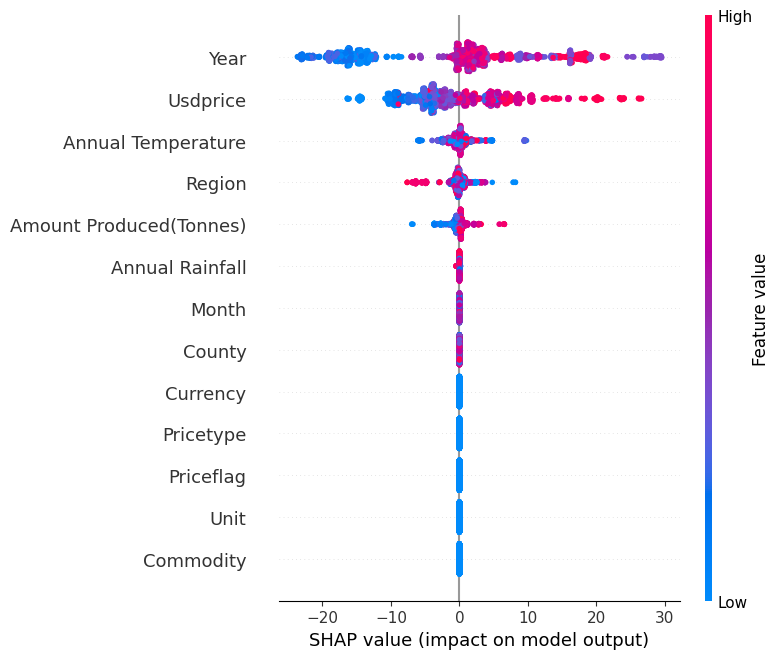

Top features:
Year                       9.582774
Usdprice                   5.544320
Annual Temperature         0.938971
Region                     0.771476
Amount Produced(Tonnes)    0.594217
Annual Rainfall            0.020537
Month                      0.003827
County                     0.001174
Commodity                  0.000000
Unit                       0.000000
dtype: float64


In [178]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Assuming expanded_df is already created

# Define your features and target
features = expanded_df.drop(columns=['Price'])  # replace 'Price' with your actual target column name
target = expanded_df['Price']

# Assuming 'categorical_df' contains the categorical columns from 'features'
categorical_df = features.select_dtypes(include=['object', 'category'])

# Identify categorical columns
categorical_cols = categorical_df.columns.tolist()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
for column in categorical_cols:
    features[column] = label_encoder.fit_transform(features[column])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Use SHAP to explain the model's predictions
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summarize the SHAP values
shap.summary_plot(shap_values, X_test)

# Get the top features
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
top_features = shap_values_df.abs().mean().sort_values(ascending=False).head(10)

print("Top features:")
print(top_features)


In [179]:
#check sk-learn version
import sklearn
print(sklearn.__version__)

1.3.2


In [180]:
#select year,month, county,region, ammount produced anual rainfall for training
X_train = expanded_df[['Year', 'Month', 'County', 'Region']]
y_train = expanded_df['Price']

In [181]:
#generate train df from top features
train_df = pd.concat([X_train, y_train], axis=1)

In [182]:
train_df.head()

,Year,Month,County,Region,Price
0,2007,January,Nyandarua,Central,22
1,2007,February,Nyandarua,Central,21.8
2,2007,March,Nyandarua,Central,21.9
3,2007,April,Nyandarua,Central,22.5
4,2007,May,Nyandarua,Central,22.3


In [183]:
train_df.shape

(9756, 5)

#Training of Modules

In [188]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

# Assuming train_df is already created

# Define your features and target
features = train_df.drop(columns=['Price'])  # replace 'Price' with your actual target column name if different
target = train_df['Price']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
for column in categorical_cols:
    features[column] = label_encoder.fit_transform(features[column])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
best_model_name = None
best_model = None
best_score = float('-inf')

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} - Mean Squared Error: {mse}, R2 Score: {r2}')

    # Save the best model based on R2 score
    if r2 > best_score:
        best_score = r2
        best_model_name = model_name
        best_model = model

    # Create a DataFrame to display the first 10 actual vs predicted values
    comparison_df = pd.DataFrame({
        'Actual Prices': y_test[:10].values,
        'Predicted Prices': y_pred[:10].flatten()
    })

    print("First 10 actual vs predicted values:")
    print(comparison_df)

# Save the best model
if best_model:
    joblib.dump(best_model, 'best_model.pkl')
    print(f'The best model ({best_model_name}) has been saved.')



RandomForest - Mean Squared Error: 0.013339821680327414, R2 Score: 0.9999469856015822
First 10 actual vs predicted values:
  Actual Prices  Predicted Prices
0         47.72           47.7393
1         37.35           37.3490
2         16.26           16.2710
3          37.5           37.5580
4         25.72           25.7980
5         26.09           26.0900
6         34.53           34.4640
7         13.14           13.1366
8         16.73           16.7300
9          81.1           81.0820
LinearRegression - Mean Squared Error: 154.76230831282504, R2 Score: 0.3849519978934698
First 10 actual vs predicted values:
  Actual Prices  Predicted Prices
0         47.72         42.323068
1         37.35         34.843397
2         16.26         23.597014
3          37.5         38.921599
4         25.72         45.141242
5         26.09         22.253954
6         34.53         38.455408
7         13.14         25.407928
8         16.73         19.427534
9          81.1         48.960442
Grad

In [189]:
X_train.head()

,Year,Month,County,Region
5804,8,11,33,5
6551,16,2,36,6
2138,3,7,38,1
3283,6,1,17,2
8528,1,11,11,6


In [190]:
#Train Ann
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure y_train is numeric
y_train = y_train.astype(float) # Convert y_train to float

# Define the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test.astype(float), y_pred) # Ensure y_test is also float
r2 = r2_score(y_test.astype(float), y_pred)

print(f'ANN - Mean Squared Error: {mse}, R2 Score: {r2}')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1072.5045 - val_loss: 176.1507
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179.2818 - val_loss: 164.3219
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 171.6404 - val_loss: 152.5516
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 164.0714 - val_loss: 140.1012
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.5484 - val_loss: 130.3532
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 142.3616 - val_loss: 124.3015
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 132.7514 - val_loss: 117.3387
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127.0335 - val_loss: 113.0784
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.2866 - val_loss: 106.5571
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 113.9989 - val_loss: 101.2440
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.7138 - val_loss: 97.3005
Epoch 12/

In [152]:
# Create a DataFrame to display the first 10 actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual Prices': y_test[:10].values,
    'Predicted Prices': y_pred[:10].flatten()
})

print("First 10 actual vs predicted values:")
print(comparison_df)

First 10 actual vs predicted values:
  Actual Prices  Predicted Prices
0         47.72         48.282944
1         37.35         36.991306
2         16.26         16.466373
3          37.5         37.628948
4         25.72         26.799835
5         26.09         26.017384
6         34.53         33.941181
7         13.14         12.777268
8         16.73         16.263380
9          81.1         81.387627


Since the random forest module appears to be the best hence we save it

In [191]:
#save random forest model using joblib
import joblib
joblib.dump(model, 'ann_model.pkl')

['ann_model.pkl']